In [1]:
%config InlineBackend.figure_formats = ['svg']

from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import math

# Planning a path to a target destination

This example demonstrates how to use (direct) optimal control to compute a path from the given start and target position of a car-like vehicle. Herein, the kinematic bicycle model is used. Besides the initial and final positions, further, the car body rotation, and the steering angle can be specified. The path in-between is planned to fulfill these terminal constraints and, further, considering boundaries on the steering angle and the steering rate.

To reduce the number of variables in the optimization problem, the control input trajectory (steering angle rate) is designed as a piecewise constant signal. Further, for each segment of the control signal, a virtual time-scaling is applied. 

In [31]:
dt = 0.1          # sampling time in case of a time scaling factor of 1
v = 1.0           # vehicle velocity (given / enforced velocity)
l_r = 3.0         # wheelbase
N_step_width = 15 # the number of samples for which the control input is hold constant

N_control_steps    = 20
max_steering_angle = 20.0
max_steering_rate  = 10
min_time_scaling   = 0.7
max_time_scaling   = 1.4

# initial state (i.e. starting position of the vehicle)
x0 = [
    0.0,               # y(t=0)
    0.0,               # x(t=0)
    np.deg2rad(-10.0), # psi(t=0)
    np.deg2rad(- 5.0), # delta(t=0)
    0.0                # t_0
]

# terminal condition for the states at final time
X_final_desired = [ 
    20.0,              # final position x
    20.0,              # final position y
    np.deg2rad(120.0), # final carbody rotation
    0.0                # steering angle in its final position
    # NOTE: herein, the final time is uncontrained
] 

In [39]:
# define the vehicle model

# symbolic variables for the states and the control inputs
X = MX.sym('X', 5)
n_control_variables = 2
u = MX.sym('u', n_control_variables) # [delta_dot, time_scale]

# The transition function f(x, u) of the discrete-time system
# Here, the Euler-discretized kinematic bicycle model is used.
# The sampling time dt can be varied by a modulation by the control input u[1] (time_scale).
Xnext = vertcat(
    X[0] + u[1] * dt*v * cos(X[3] + X[2]),  # X[0] - x
    X[1] + u[1] * dt*v * sin(X[3] + X[2]),  # X[1] - y
    X[2] + u[1] * dt*v/l_r * sin( X[3] ),   # X[2] - psi
    X[3] +        dt * u[0],                # X[3] - delta,  u - delta_dot
    X[4] + u[1] * dt                        # X[4] - time,  
)
y = X[2]

f = Function('f',[X, u],[ Xnext , y ])      # transition function of the discrete-time system and the output [ f(x, u), x[2] ]

# define a function that performs N steps of a sucessive 
# application of the system function f to the states
# (a forward simulation of the system for N steps)
F_vehicle_sys       = f.mapaccum('F_vehicle_sys', N_step_width)   # using mapaccum: the output of the function is the whole discrete state trajectory 
F_vehicle_sys_final = f.fold(N_step_width)                        # using fold: the output of the function is just the state at final time  



In [33]:
def define_boundaries_on_control_variable( N_control_steps, max_steering_rate, min_time_scaling, max_time_scaling ):
    
    lbx = np.zeros((N_control_steps, 2))
    lbx[:,0] = -np.deg2rad( max_steering_rate )  # lower bound for delta_dot
    lbx[:,1] = min_time_scaling                  # lower bound for time_scale

    ubx = np.zeros((N_control_steps, 2))
    ubx[:,0] = +np.deg2rad( max_steering_rate )  # upper bound for delta_dot
    ubx[:,1] = max_time_scaling                  # upper bound for time_scale

    return lbx, ubx



In [34]:
def symbolic_sample_and_hold_forward_simulation(F_system, x0, u, N_step_width):
    """
        apply a piecewise constant input to the system F_system (sample & hold)
        
        This function operates on symbolic Casadi variables
        
        F_system      - the function that performs a forward simulation of the system as returned by mapaccum
        x0            - the initial states
        u             - the samples of the control input
        N_step_width  - the number of samples for which the control input is hold constant
    """
    x = x0    
    N_control_steps = u.size()[0]

    all_res = []
    for k in range( N_control_steps ):

        u_ = u[k,:]

        res = F_system(x , u_.T)
        all_res.append( res )

        # extract terminal state for the current segment
        x = res[0][:,N_step_width-1]

    # concatenate casadi variables
    X_trajectory = horzcat(
        *tuple( 
            [ all_res[k][0] for k in range(len(all_res)) ]
        ) 
    )

    return X_trajectory

In [35]:

# Control vector
u = MX.sym('u', N_control_steps, n_control_variables)

# loop over all control variables
x = MX( x0 )  # Initial state

# build system with piecewise constant control inputs (defined by u)
X_trajectory = symbolic_sample_and_hold_forward_simulation(F_vehicle_sys, x0, u, N_step_width)

# state at the final time
x_f = X_trajectory[:, -1]

# extract the traces for each states
x_trace      = X_trajectory[0,:]
y_trace      = X_trajectory[1,:]
psi_trace    = X_trajectory[2,:]
delta_trace  = X_trajectory[3,:]
time         = X_trajectory[4,:]

N_total_samples = x_trace.size()[1]

# NLP declaration
nlp = {
    'x':reshape(u, 2 * N_control_steps, 1), # reshape to flatten the control variables
    'f':dot( u, u ),
    'g': vertcat(
        x_f[0],
        x_f[1],
        x_f[2],
        x_f[3],
        # x_trace.T,
        # y_trace.T,
        delta_trace.T  # streering angle trace
    )
}

# define boundaries for the function g

# enforce that the final states (vehicle position, ...) are reached
lbg = np.array( X_final_desired )
ubg = np.array( X_final_desired )

#
#lbg = np.concatenate( ( lbg, -1 * np.ones(N_total_samples) ) )
#ubg = np.concatenate( ( ubg, 28.5 * np.ones(N_total_samples) ) )

# define boundaries for the steering angle
lbg = np.concatenate( ( lbg, np.deg2rad( -max_steering_angle ) * np.ones(N_total_samples) ) )
ubg = np.concatenate( ( ubg, np.deg2rad( +max_steering_angle ) * np.ones(N_total_samples) ) )

lbx, ubx = define_boundaries_on_control_variable(N_control_steps, max_steering_rate, min_time_scaling, max_time_scaling)

# Solve using IPOPT
solver = nlpsol('solver','ipopt',nlp)


res = solver(
    x0  = 0.0,
    lbg = lbg,
    ubg = ubg,
    lbx = reshape(lbx, 2 * N_control_steps, 1),
    ubx = reshape(ubx, 2 * N_control_steps, 1)
)

# the optimal control variable
u_star = np.array( reshape(res["x"], N_control_steps, 2) )


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      140
Number of nonzeros in inequality constraint Jacobian.:     3150
Number of nonzeros in Lagrangian Hessian.............:      820

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [36]:
def numerical_sample_and_hold_forward_simulation(F_vehicle_sys, x0, u_star, N_step_width):
    """
        apply a piecewise constant input to the system F_system (sample & hold)
        
        This function operates on numeric Numpy vectors 
        
        F_system       - the function that performs a forward simulation of the system as returned by mapaccum
        x0             - the initial states
        u              - the samples of the control input
        N_step_width   - the number of samples for which the control input is hold constant
    """
    x = x0

    all_res = []
    for u in u_star:
        
        res = F_vehicle_sys(x , u)
        all_res.append( res )

        # extract terminal state for the current segment
        x = res[0][:,N_step_width-1]

    # concatenate casadi variables
    X_all_casadi = horzcat(
        *tuple(
            [ all_res[k][0] for k in range(len(all_res)) ]
        )
    )

    return X_all_casadi

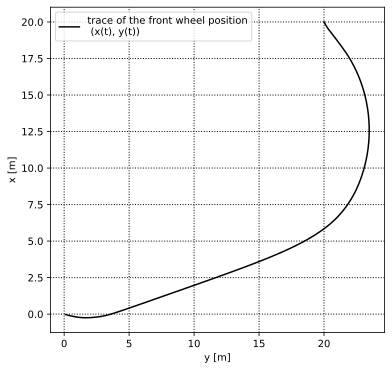

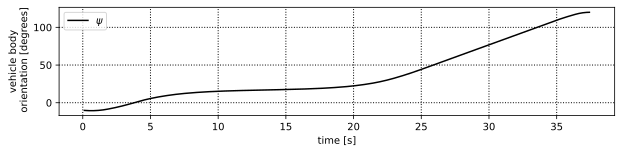

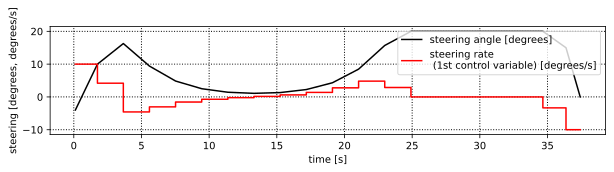

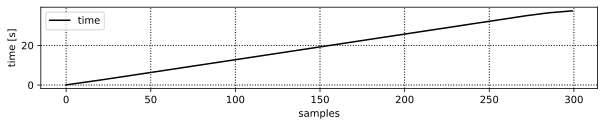

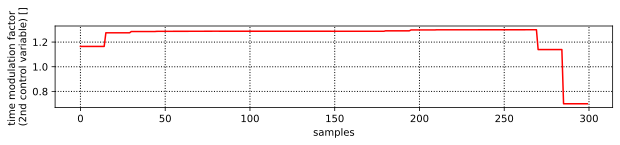

In [38]:
# Test simulation for optimal input sequence to the state trajectories


#
# simulate
# 

X_all_casadi = numerical_sample_and_hold_forward_simulation(F_vehicle_sys, x0, u_star, N_step_width)

# build the piecewise constant conrol variable
u_delta_dot_star = np.concatenate( tuple([ np.ones(N_step_width) * u_delta for u_delta in u_star[:,0] ]) )
u_time_star      = np.concatenate( tuple([ np.ones(N_step_width) * u_time  for u_time  in u_star[:,1] ]) )

# extract state variables
x_trace      = np.array( X_all_casadi[0,:] )[0]
y_trace      = np.array( X_all_casadi[1,:] )[0]
psi_trace    = np.array( X_all_casadi[2,:] )[0]
delta_trace  = np.array( X_all_casadi[3,:] )[0]
time         = np.array( X_all_casadi[4,:] )[0]

# concatenate numerical data
X_all = np.transpose( np.concatenate( (x_acc) ) )

# plot the results
plt.figure(figsize=(6, 6), dpi=100)
plt.plot( x_trace, y_trace, 'k' )
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('y [m]')
plt.ylabel('x [m]')
plt.legend(['trace of the front wheel position\n (x(t), y(t))'])
plt.show()

plt.figure(figsize=(10,2), dpi=100)
plt.plot( time, np.rad2deg( psi_trace ), 'k' )
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('time [s]')
plt.ylabel('vehicle body\n orientation [degrees]')
plt.legend(['$\psi$'])
plt.show()

plt.figure(figsize=(10,2), dpi=100)
plt.plot( time, np.rad2deg( delta_trace ), 'k' )
plt.step( time, np.rad2deg( u_delta_dot_star ), 'r' )
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('time [s]')
plt.ylabel('steering [degrees, degrees/s]')
plt.legend(['steering angle [degrees]', 'steering rate\n (1st control variable) [degrees/s]' ])
plt.show()

plt.figure(figsize=(10,1.5), dpi=100)
plt.plot( time, 'k' )
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('samples')
plt.ylabel('time [s]')
plt.legend(['time'])
plt.show()

plt.figure(figsize=(10,1.5), dpi=100)
plt.plot( u_time_star, 'r' )
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('samples')
plt.ylabel('time modulation factor \n(2nd control variable) []')
plt.show()
